# Combining SNOMED hierarchy path lengths and word embedding cosine similarities

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [2]:
embedding_similarity_matrix = pd.read_csv('embedding_similarity_matrix.csv', index_col=0)
snomed_distance_matrix = pd.read_csv('snomed_distance_matrix.csv', index_col=0)

concept_df = pd.read_csv('../Standardization/athena_vocabulary/CONCEPT.csv', sep='\t', dtype={'concept_code': str, 'concept_id': str}, low_memory=False)

In [3]:
def normalize_matrix(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    return (matrix - min_val) / (max_val - min_val)

snomed_distance_matrix_norm = normalize_matrix(snomed_distance_matrix)
embedding_similarity_matrix_norm = normalize_matrix(embedding_similarity_matrix)

In [4]:
embedding_distance_matrix_norm = 1 - embedding_similarity_matrix_norm

In [16]:
alpha = 0.5  # weight for snomed distance
beta = 1 - alpha  # weight for embedding distance

combined_distance_matrix = alpha * snomed_distance_matrix_norm + beta * embedding_distance_matrix_norm

In [17]:
code_to_name = dict(zip(concept_df["concept_id"], concept_df["concept_name"]))
labels = [code_to_name[i] for i in list(combined_distance_matrix.columns)]

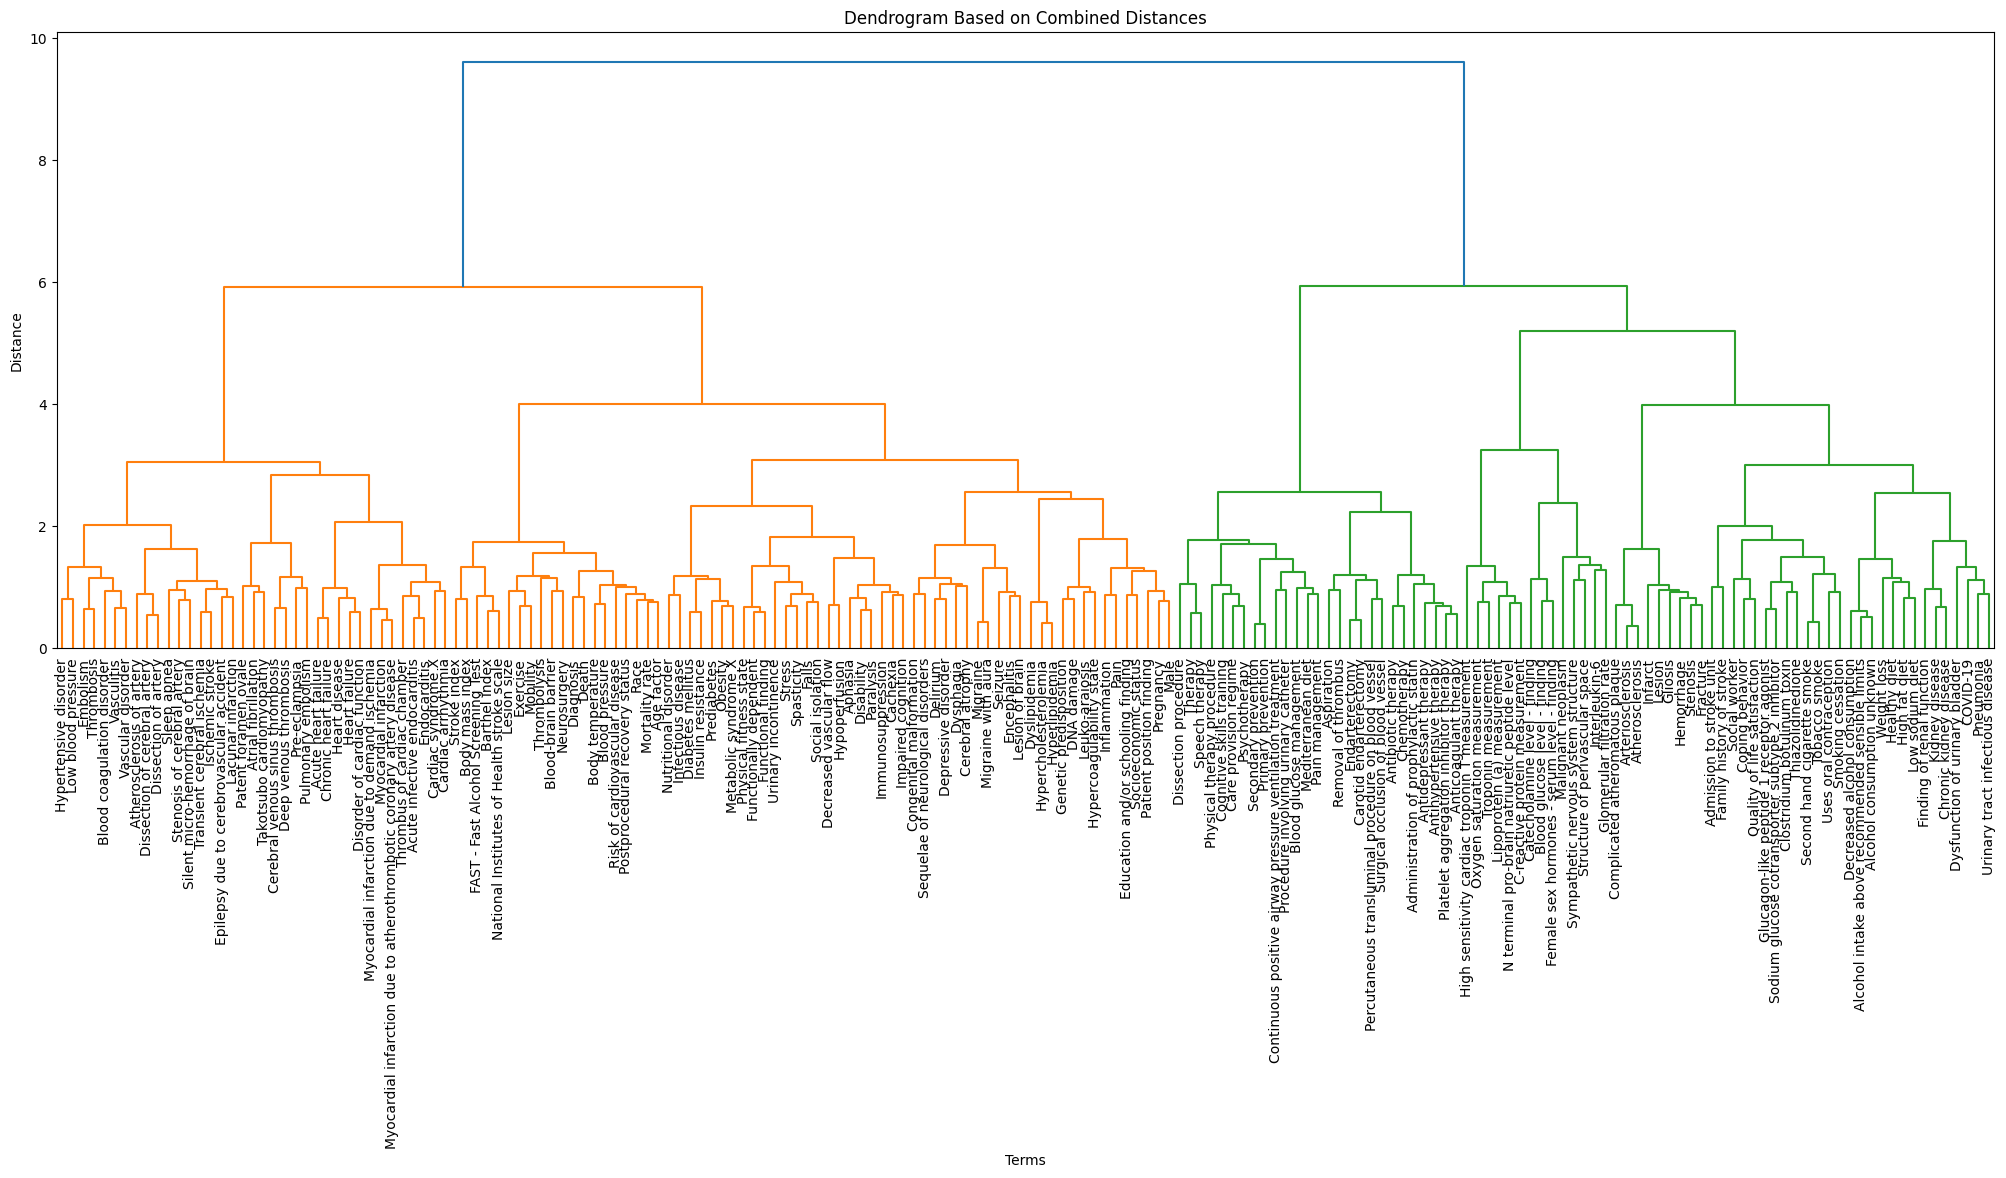

In [18]:
linkage_matrix = linkage(combined_distance_matrix, method='ward')

plt.figure(figsize=(25, 8))
dendrogram(linkage_matrix, labels=labels, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogram Based on Combined Distances")
plt.xlabel("Terms")
plt.ylabel("Distance");

In [19]:
clusters = fcluster(linkage_matrix, t=2, criterion='distance')

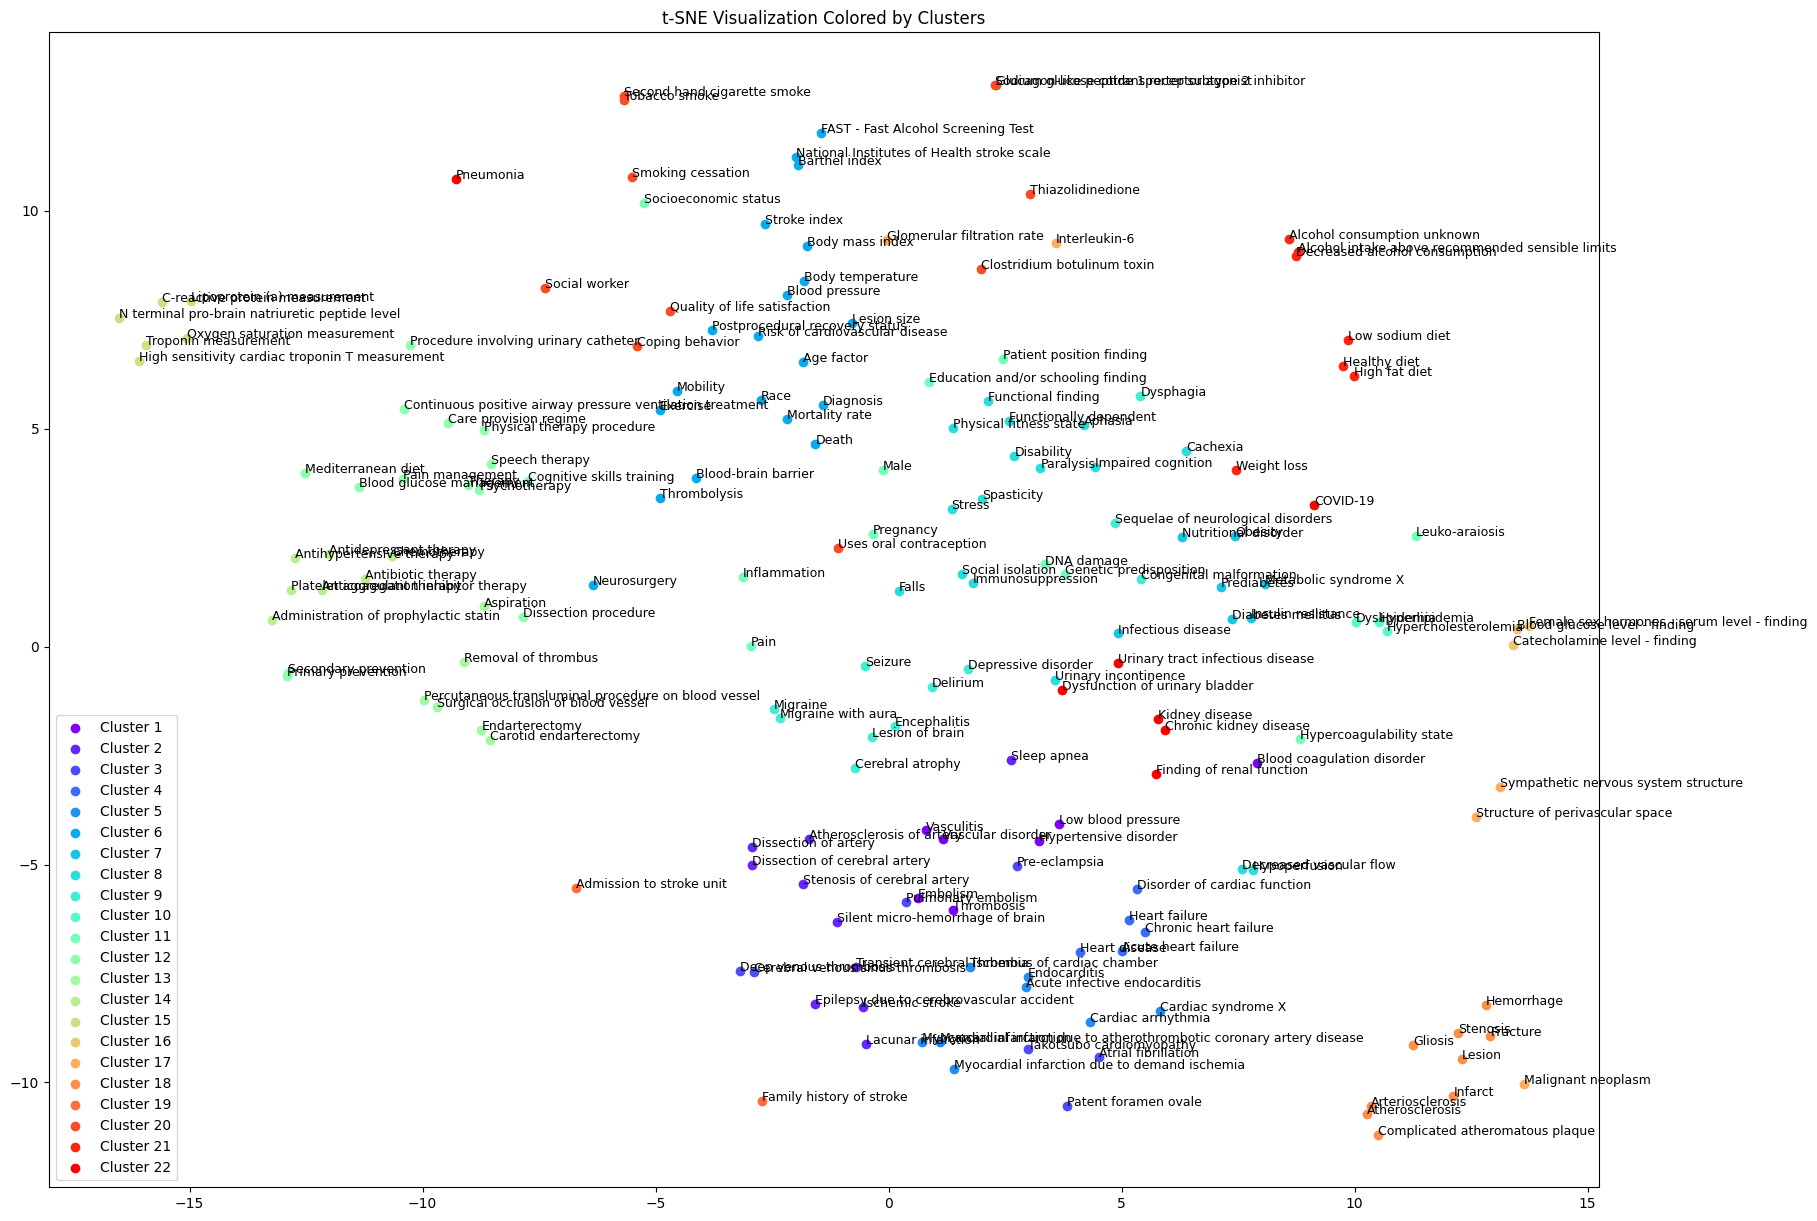

In [20]:
num_clusters = len(set(clusters))
colors = plt.cm.rainbow(np.linspace(0, 1, num_clusters))

tsne = TSNE(metric="precomputed", init='random', random_state=42)
tsne_result = tsne.fit_transform(combined_distance_matrix)

plt.figure(figsize=(20, 15))
for cluster_id in range(1, num_clusters + 1):
    cluster_points = tsne_result[clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", color=colors[cluster_id - 1])

for i, code in enumerate(labels):
    plt.text(tsne_result[i, 0], tsne_result[i, 1], code, fontsize=9)

plt.title("t-SNE Visualization Colored by Clusters")
plt.legend();

In [21]:
cluster_df = pd.DataFrame({'term': combined_distance_matrix.index, 'cluster': clusters})
cluster_df_count = pd.DataFrame(cluster_df.cluster.value_counts()).reset_index()
cluster_df['concept_name'] = [code_to_name[str(i)] for i in cluster_df.term]
cluster_df = cluster_df.groupby('cluster')['concept_name'].apply(list).reset_index()
cluster_df.columns = ['cluster', 'concept_names']
cluster_df = cluster_df.merge(cluster_df_count, how='left', on='cluster')
cluster_df

,cluster,concept_names,count
0,1,"[Hypertensive disorder, Low blood pressure, Va...",7
1,2,"[Sleep apnea, Stenosis of cerebral artery, Dis...",10
2,3,"[Atrial fibrillation, Takotsubo cardiomyopathy...",7
3,4,"[Heart failure, Heart disease, Disorder of car...",5
4,5,"[Myocardial infarction due to demand ischemia,...",8
5,6,"[Risk of cardiovascular disease, Race, Blood-b...",20
6,7,"[Diabetes mellitus, Insulin resistance, Predia...",7
7,8,"[Cachexia, Urinary incontinence, Functionally ...",16
8,9,"[Dysphagia, Migraine, Delirium, Seizure, Encep...",11
9,10,"[Hypercholesterolemia, Dyslipidemia, Hyperlipi...",3


In [33]:
import re

In [40]:
my_cluster = 2
text_string = str(cluster_df.concept_names[my_cluster-1])
text_string = re.sub(r"[^a-zA-Z0-9, ]", "", text_string)
text_string

'Sleep apnea, Stenosis of cerebral artery, Dissection of cerebral artery, Silent microhemorrhage of brain, Epilepsy due to cerebrovascular accident, Transient cerebral ischemia, Lacunar infarction, Atherosclerosis of artery, Ischemic stroke, Dissection of artery'